# Drifter evaluation example

In [49]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
from cmocean import cm
from datetime import datetime, timedelta
from dateutil.parser import parse
from scipy.io import loadmat
from itertools import repeat
from glob import glob
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools

%matplotlib inline
plt.rcParams['font.size'] = 12

In [3]:
# Define paths
drifters = loadmat('/ocean/shared/drifters/data/L2/drifters_L2.mat')['drifters'][0]
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'out': '/data/bmoorema/results/opendrift',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
daterange1 = [parse(d) for d in ['2016 Jul 19', '2016 Aug 1']]
daterange2 = [parse(d) for d in ['2017 Nov 27', '2017 Dec 15']]

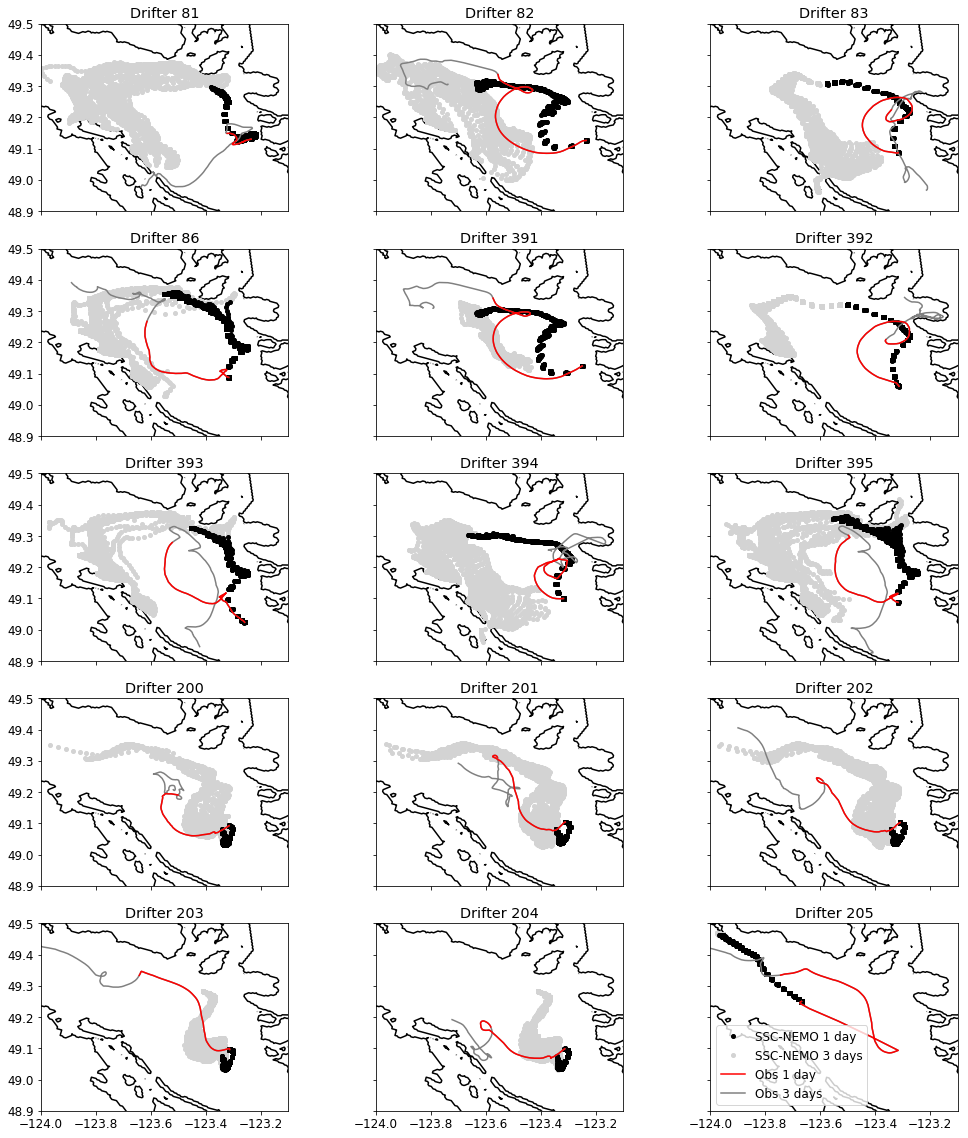

In [51]:
fig, axs = plt.subplots(5, 3, figsize=(17, 20))
axs = axs.reshape(-1)
IDs = [81, 82, 83, 86, 391, 392, 393, 394, 395, 200, 201, 202, 203, 204, 205]
for ax, ID in zip(axs, IDs):
    
    ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
    ax.set_xlim([-124, -123.1])
    ax.set_ylim([48.9, 49.5])
    viz_tools.set_aspect(ax)
    if ID not in [203, 204, 205]: ax.xaxis.set_ticklabels('')
    if ID not in [81, 86, 393, 200, 203]: ax.yaxis.set_ticklabels('')
    ax.set_title(f'Drifter {ID}')
    
    with xr.open_dataset(os.path.join(paths['out'], 'results', f'drifter_{ID}.nc')) as ds:
        SSC72 = ax.plot(ds.lon[:, :72], ds.lat[:, :72], 'o', color='lightgray', markersize=4)
        SSC24 = ax.plot(ds.lon[:, :24], ds.lat[:, :24], 'ko', markersize=4)
    
    i = 0
    if ID == 391: i = 1
    dindex = np.where(drifters['id'].astype(int) == ID)[0][i]
    t24 = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - 1).argmin()
    t72 = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - 3).argmin()
    OBS72 = ax.plot(drifters['lon'][dindex][:t72], drifters['lat'][dindex][:t72], '-', color='gray')
    OBS24 = ax.plot(drifters['lon'][dindex][:t24], drifters['lat'][dindex][:t24], 'r-')
ax.legend([SSC24[0], SSC72[0], OBS24[0], OBS72[0]], ['SSC-NEMO 1 day', 'SSC-NEMO 3 days', 'Obs 1 day', 'Obs 3 days'])

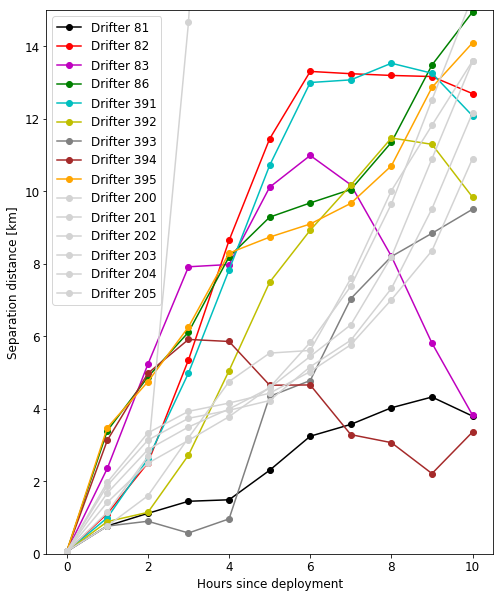

In [53]:
fig, ax = plt.subplots(figsize=(8, 10))

ax.set_xlabel('Hours since deployment')
ax.set_ylabel('Separation distance [km]')
ax.set_ylim([0, 15])

for ID, color in zip(IDs, ['k', 'r', 'm', 'g', 'c', 'y', 'gray', 'brown', 'orange', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray', 'lightgray']):
    diffs = []
    i = 0
    if ID == 391: i = 1

    with xr.open_dataset(os.path.join(paths['out'], 'results', f'drifter_{ID}.nc')) as ds:
        for hour in range(11):
            dindex = np.where(drifters['id'].astype(int) == ID)[0][i]
            tindex = abs(drifters['mtime'][dindex] - drifters['mtime'][dindex][0] - hour/24).argmin()
            sides2 = []
            for key, corr in zip(['lon', 'lat'], [72, 111]):
                sides2.append(((ds[key][:, hour] - drifters[key][dindex][tindex]) * corr)**2)
            diffs.append(float(np.sqrt(sum(sides2)).mean()))
    ax.plot(range(11), diffs, '-o', color=color, label=f'Drifter {ID}')
ax.legend()
#fig.savefig('/home/bmoorema/Desktop/drifters2016_jul_diff.pdf', bbox_inches='tight')